# Cryptocurrency Covariance Analysis

In [1]:
import os, sys
import pathlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from pylab import rcParams
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

In [2]:
feature_type = 'volatility_pcnt'

In [3]:
feature_list = ['symbol','pr_count','issues_count','commit_add_sum','commit_del_sum','commit_count','star_count','close','high','low','open','usd_market_cap','usd_volume']

In [4]:
rcParams['figure.figsize'] = 15, 12

### Load Currency Price Histories

In [5]:
def show_correlation_matrix(df):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df, interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Coin Correlation Matrix')
    labels=[x.split('_',1)[0] for x in df.columns.values]
    ax1.set_xticks(np.arange(len(labels)))
    ax1.set_xticklabels(labels,fontsize=10, rotation=90)
    ax1.set_yticks(np.arange(len(labels)))
    ax1.set_yticklabels(labels,fontsize=10)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=range(-1,10))
    fig.set_size_inches(18.5, 18.5)
    plt.show()

In [6]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [7]:
def generate_clusters(timeSeries):
    timeSeries = timeSeries.replace([np.inf, -np.inf, np.nan], 0.001)

    z_euclidean = hac.linkage(timeSeries, method='ward', metric='euclidean'),"Euclidean"
#     z_minkowski = hac.linkage(timeSeries, method='ward', metric='minkowski'),"Minowski"
#     z_cityblock = hac.linkage(timeSeries, method='ward', metric='cityblock'),"Cityblock"
#     z_cosine = hac.linkage(timeSeries, method='ward', metric='cosine'),"Cosine"
#     z_correlation = hac.linkage(timeSeries, method='ward', metric='correlation'),"Correlation"

    p = 12
    max_d = 50
    
    for z, name in [z_euclidean]:
                                #ValueError: Method 'ward' requires the distance metric to be Euclidean
        print(name, "/", "Ward")
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('coin')
        plt.ylabel('distance')
        fancy_dendrogram(
            z,
            p=p,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
            max_d=max_d,
            annotate_above=1,
            color_threshold=8,
            labels=[x.split('_',1)[0] for x in timeSeries.columns.values]
        )
        plt.show()

In [8]:
dfs = []
hist_symbol = []
columns = ['close','open','high','low']

for path in pathlib.Path("CoinCSVs").iterdir():
    filename = path.name
    symbol = filename.split('.')[0]
    sdf = pd.read_csv(path,
                          usecols=[1,2,3,4,],
                          header=0,
                          names=[('{}_'+feature_type).format(symbol) for feature_type in columns])
    dfs.append(sdf)
    hist_symbol.append(symbol)
hist_symbol = set(hist_symbol)

In [9]:
for df in dfs:
    symbol = df.columns.values[0].split("_",1)[0]
    df[symbol+'_return_pcnt'] = (df[symbol+"_close"] - df[symbol+"_open"]) / df[symbol+"_close"]
    df[symbol+'_volatility_pcnt'] = (df[symbol+"_high"] - df[symbol+"_low"]) / ((df[symbol+"_high"] + df[symbol+"_low"]) / 2)

In [10]:
feature_df = pd.concat([x[x.columns.values[0].split("_",1)[0]+'_'+feature_type] for x in dfs], axis=1)
feature_df.describe()

,DRGN_volatility_pcnt,BCH_volatility_pcnt,BTC_volatility_pcnt,XRB_volatility_pcnt,RHOC_volatility_pcnt,SNT_volatility_pcnt,XRP_volatility_pcnt,BTG_volatility_pcnt,BCN_volatility_pcnt,REP_volatility_pcnt,...,QTUM_volatility_pcnt,ARK_volatility_pcnt,ZEC_volatility_pcnt,DASH_volatility_pcnt,DCR_volatility_pcnt,FCT_volatility_pcnt,ADA_volatility_pcnt,LTC_volatility_pcnt,ZRX_volatility_pcnt,DOGE_volatility_pcnt
count,0.0,145.000000,191.000000,146.000000,100.000000,175.000000,34.000000,68.000000,6.000000,193.000000,...,160.000000,9.000000,110.000000,89.000000,105.000000,140.000000,128.000000,112.000000,113.000000,2.0
mean,NaN,0.390893,0.399573,0.704367,0.481633,0.478086,0.766339,0.680801,0.496261,0.521132,...,0.913254,0.601852,0.795901,0.468568,0.355817,0.956963,0.478601,0.647090,0.575238,0.0
std,NaN,0.789429,0.772115,0.900530,1.092004,0.730880,0.809373,0.902455,1.241082,0.731744,...,0.838269,0.959433,1.147672,0.784393,0.986453,0.710948,0.760506,0.808832,0.824109,0.0
min,NaN,-1.854167,-2.000000,-1.999786,-1.982984,-2.000000,-1.973573,-1.887002,-1.941443,-2.000000,...,-1.916475,-0.666667,-2.000000,-2.000000,-2.000000,-1.689840,-2.000000,-1.964956,-1.766082,0.0
25%,NaN,0.000000,0.000000,0.041321,-0.214055,0.000000,0.471212,0.000000,0.618215,0.048000,...,0.344346,0.000000,0.134468,0.000000,-0.132231,0.457094,0.148507,0.115987,0.037701,0.0
50%,NaN,0.294650,0.298677,0.521137,0.461748,0.400000,0.814005,0.392580,0.871423,0.391467,...,1.096967,0.482759,1.108911,0.411765,0.330097,1.086057,0.444894,0.536037,0.537724,0.0
75%,NaN,0.833333,0.855547,1.479631,1.349568,0.995739,1.252000,1.453623,1.019292,1.069182,...,1.620023,1.555556,1.779609,1.000000,1.000000,1.491525,0.932016,1.285756,1.263682,0.0
max,NaN,2.000000,2.000000,2.000000,2.000000,2.000000,1.989135,2.000000,1.573770,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.0


In [11]:
cov_df = feature_df.cov()
cov_df.describe()

,DRGN_volatility_pcnt,BCH_volatility_pcnt,BTC_volatility_pcnt,XRB_volatility_pcnt,RHOC_volatility_pcnt,SNT_volatility_pcnt,XRP_volatility_pcnt,BTG_volatility_pcnt,BCN_volatility_pcnt,REP_volatility_pcnt,...,QTUM_volatility_pcnt,ARK_volatility_pcnt,ZEC_volatility_pcnt,DASH_volatility_pcnt,DCR_volatility_pcnt,FCT_volatility_pcnt,ADA_volatility_pcnt,LTC_volatility_pcnt,ZRX_volatility_pcnt,DOGE_volatility_pcnt
count,0.0,36.000000,36.000000,37.000000,35.000000,36.000000,32.000000,33.000000,26.000000,36.000000,...,36.000000,27.000000,35.000000,35.000000,35.000000,36.000000,36.000000,36.000000,36.000000,6.0
mean,NaN,0.054957,0.041271,0.024561,0.050912,0.056335,0.033182,-0.001714,0.050487,0.010052,...,0.071059,-0.107153,0.053961,0.049753,0.186919,0.058658,0.002199,0.016155,0.027367,0.0
std,NaN,0.226453,0.167388,0.171391,0.265719,0.176936,0.218482,0.276275,0.794720,0.148135,...,0.225291,0.414436,0.345487,0.288869,0.409838,0.218423,0.182067,0.278470,0.200412,0.0
min,NaN,-0.169461,-0.151170,-0.301346,-0.421838,-0.166146,-0.377375,-0.954763,-3.049591,-0.382359,...,-0.228762,-1.146978,-0.686030,-1.146978,-0.241335,-0.499085,-0.576584,-0.673163,-0.551802,0.0
25%,NaN,-0.047045,-0.048813,-0.057321,-0.070034,-0.036058,-0.107695,-0.071122,-0.238596,-0.053152,...,-0.052228,-0.433094,-0.057061,-0.011776,0.002324,-0.020824,-0.079807,-0.100442,-0.027245,0.0
50%,NaN,0.015649,0.003244,0.021374,0.012272,0.001925,0.040919,0.015099,0.115689,0.009498,...,0.022617,-0.038096,0.034251,0.039107,0.101207,0.029294,-0.000900,0.009344,0.019281,0.0
75%,NaN,0.054096,0.081453,0.073830,0.094897,0.079248,0.120581,0.114975,0.363508,0.051967,...,0.077397,0.097510,0.133666,0.114158,0.220596,0.085089,0.060941,0.068055,0.080969,0.0
max,NaN,1.121201,0.653318,0.810955,1.192474,0.683201,0.655085,0.814424,1.540284,0.535449,...,0.702695,0.920512,1.317152,0.906376,2.118200,0.769465,0.578369,1.072364,0.679156,0.0


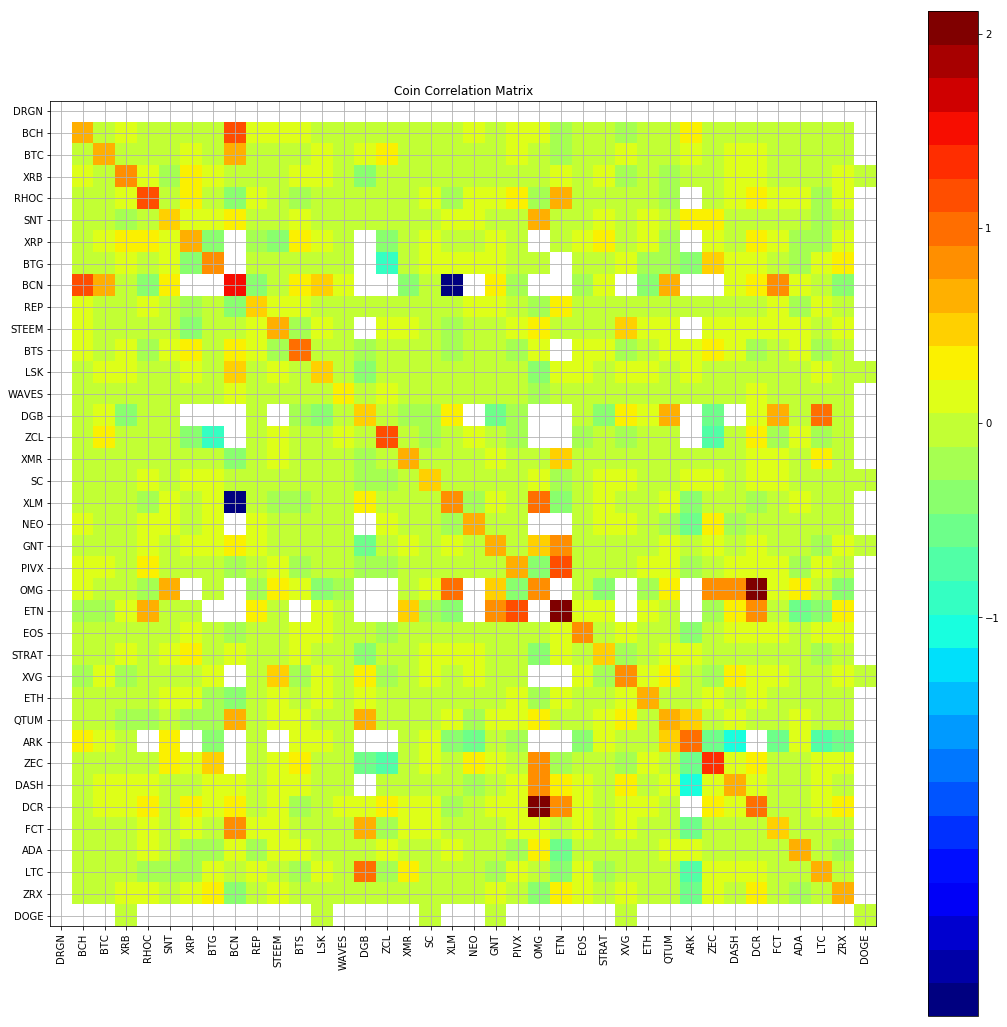

In [12]:
show_correlation_matrix(cov_df)

Euclidean / Ward


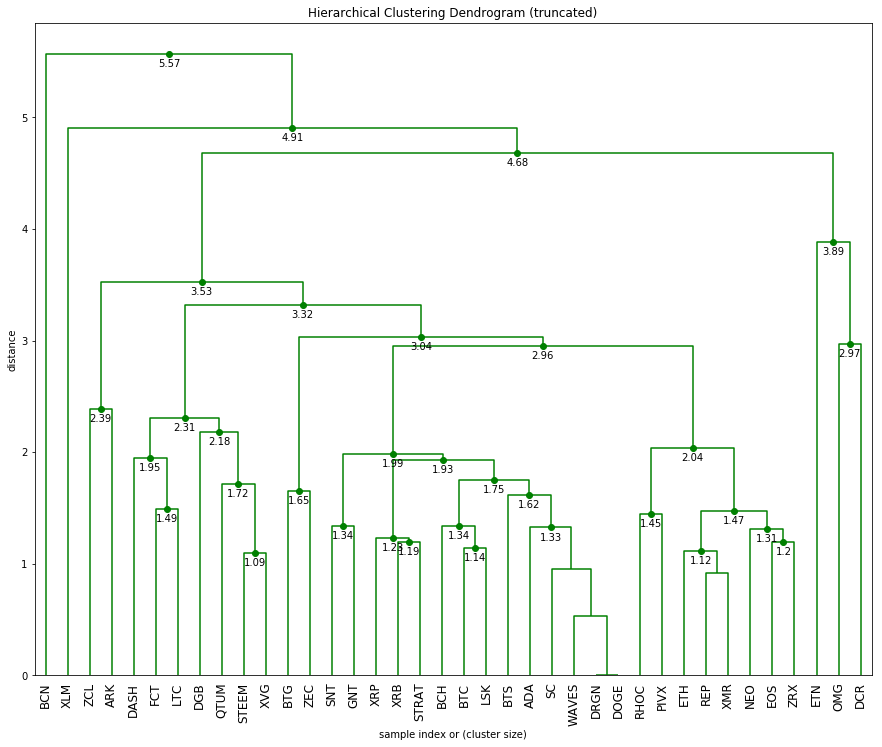

In [13]:
generate_clusters(cov_df)